In [1]:
import time
import math
import random
from random import shuffle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from sklearn.metrics import confusion_matrix
from datetime import timedelta
import os
import glob
from sklearn.utils import shuffle
from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib
%matplotlib inline
correct_sum = 0

In [2]:
train_path = 'E:/train'
img_size = 64
chnls = 3
val_size = 0.20
num_data = 200
batch_size = 50
test_batch_size = 50
map1 = 8
map2 = 16
num_fc1 = 2048 
num_fc2 = 38
num_outputs = 38
reduce1x1 = 2
img_flat = img_size*img_size*3

In [3]:
classes = ['Apple_Apple_scab',
           'Apple_Black_rot','Apple_healthy','Apple_Cedar_apple_rust','Blueberry_healthy','Cherry_healthy',
           'Cherry_Powdery_mildew','Corn_Cercospora_leaf_spot Gray_leaf_spot','Corn_Common_rust','Corn_Northern_Leaf_Blight',
           'Corn_healthy','Grape_Black_rot','Grape_Esca_(Black_Measles)','Grape_healthy','Grape_Leaf_blight',
           'Orange_Haunglongbing','Peach_Bacterial_spot','Pepper_bell_Bacterial_spot','Pepper_bell_healthy',
           'Peach_healthy','Potato_Early_blight','Potato_healthy','Potato_Late_blight','Raspberry_healthy',
           'Soybean_healthy','Squash_Powdery_mildew','Strawberry_healthy','Strawberry_Leaf_scorch',
           'Tomato_Bacterial_spot','Tomato_Tomato_Yellow_Leaf_Curl_Virus','Tomato_Tomato_mosaic_virus','Tomato_Target_Spot',
           'Tomato_Early_blight','Tomato_Spider_mites_Two-spotted_spider_mite','Tomato_Septoria_leaf_spot',
           'Tomato_Leaf_Mold','Tomato_Late_blight','Tomato_healthy']

In [4]:
def load_img_data(train_path , img_size, num_data, classes ,val_size):
    images = []
    labels = []
    cls_name = []
    count_img:int = 0
    for fold_name in classes:
        index = classes.index( fold_name)
        data_path = os.path.join(train_path , fold_name , '*g')
        count_img = 0
        files = glob.glob( data_path )
        for img_path in files:
            
            if num_data < count_img:
                break
            label = np.zeros( len(classes) )
            label[index] = 1.0
            labels.append( label )
            cls_name.append( fold_name )
            img = cv2.imread( img_path )
            img = cv2.resize(img, (img_size, img_size), cv2.INTER_LINEAR)
            images.append(img)
            count_img+=1
            
        print('Loading {} files (Index: {}) no of samples {}  '.format( fold_name, index , count_img - 1 ))
        
    images = np.array( images )
    labels = np.array( labels )
    cls_name = np.array( cls_name )
    
    images = images.astype(np.float32)
    images = np.multiply(images, 1.0 / 255.0)
    
    
    print( " data load succesfully ")
    
    
    if not isinstance(val_size, float):
        print( " invalid val_size or type ")

    images, labels, cls_name = shuffle(images, labels, cls_name)
    
    val_size = int(val_size * images.shape[0])
    
    train_img = images[val_size:]
    train_label = labels[val_size:]
    train_cls = cls_name[val_size:]
    
    val_img = images[:val_size]
    val_label = labels[:val_size]
    val_cls = cls_name[:val_size]
    

    

    del images
    del labels
    del cls_name
    
    
    
    return train_img, train_label, val_img ,val_label,train_cls,val_cls


In [5]:
train_img, train_label, val_img, val_label, train_cls, val_cls = load_img_data(train_path, img_size, num_data, classes, val_size)  

print ( "train images :  {} ".format(len( train_img )))
print ( "validation images : {}".format(len(val_img )))

Loading Apple_Apple_scab files (Index: 0) no of samples 200  
Loading Apple_Black_rot files (Index: 1) no of samples 200  
Loading Apple_healthy files (Index: 2) no of samples 200  
Loading Apple_Cedar_apple_rust files (Index: 3) no of samples 200  
Loading Blueberry_healthy files (Index: 4) no of samples 200  
Loading Cherry_healthy files (Index: 5) no of samples 200  
Loading Cherry_Powdery_mildew files (Index: 6) no of samples 200  
Loading Corn_Cercospora_leaf_spot Gray_leaf_spot files (Index: 7) no of samples 200  
Loading Corn_Common_rust files (Index: 8) no of samples 200  
Loading Corn_Northern_Leaf_Blight files (Index: 9) no of samples 200  
Loading Corn_healthy files (Index: 10) no of samples 200  
Loading Grape_Black_rot files (Index: 11) no of samples 200  
Loading Grape_Esca_(Black_Measles) files (Index: 12) no of samples 200  
Loading Grape_healthy files (Index: 13) no of samples 200  
Loading Grape_Leaf_blight files (Index: 14) no of samples 200  
Loading Orange_Haunglon

In [6]:
def img_cls_rt( img_lbl ):
    for i in range( 0, 38):
        if img_lbl[i] == 1:
            return i

In [7]:
def plot_images(images, cls_true, cls_pred=None):
    
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))
        
        
    images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])
    
    
    fig, axes = plt.subplots( 3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        ax.imshow(cv2.cvtColor(images[i].reshape(img_size, img_size, 3),cv2.COLOR_BGR2RGB))

        if cls_pred is None:
            xlabel = "{0}".format( classes[img_cls_rt(cls_true[i]) ]  )
        else:
            xlabel = "T: {0},P: {1}".format( classes[img_cls_rt(cls_true[i])] , cls_pred[i])

        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])
    
  
    plt.show()

    
  

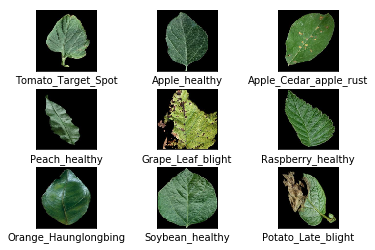

In [8]:
images, cls_true  = train_img, train_label
plot_images(images=images, cls_true=cls_true)

In [9]:
for i in range(0 , len( train_img )):
    if not train_cls[i] == classes[img_cls_rt(train_label[i])]:
        print ( " data load fault ")

In [10]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [11]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [12]:
def new_conv_layer(input,              
                   num_input_channels, 
                   filter_size,        
                   num_filters,        
                   use_pooling = False):

   
    shape = [filter_size, filter_size, num_input_channels, num_filters]

   
    weights = new_weights(shape=shape)

   
    biases = new_biases(length=num_filters)
    
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    layer += biases
    
    

    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
        
    return layer, weights

In [13]:
def flatten_layer(layer): 

    layer_shape = layer.get_shape()

    num_features = layer_shape[1:4].num_elements()
    
    layer_flat = tf.reshape(layer, [-1, num_features])

    return layer_flat, num_features

In [14]:
def new_fc_layer(input,          
                 num_inputs,     
                 num_outputs,    
                 use_relu=True,
                 drop_out = True): 

    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    layer = tf.matmul(input, weights) + biases
    if drop_out:
        layer = tf.nn.dropout(layer , 0.75)

    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [15]:
X = tf.placeholder(tf.float32, shape=[ None, img_size, img_size, chnls] , name = 'x')
Y = tf.placeholder(tf.float32, shape=[ None, num_outputs], name = 'y')
Y_ = tf.argmax( Y, axis=1)
     
#validation data
val_X = tf.placeholder(tf.float32,shape=( None, img_size, img_size, chnls))
 
#training data
train_X = tf.placeholder(tf.float32,shape=(None, img_size, img_size, chnls))


## input 

In [16]:
num_channels_1 = 3
filter_size_1 = 1
num_filters_1 = 32

layer_conv_1, weights_conv_1 = \
    new_conv_layer(input= X,
                   num_input_channels = num_channels_1,
                   filter_size = filter_size_1,
                   num_filters = num_filters_1,
                   use_pooling = False)
layer_conv_1

<tf.Tensor 'add:0' shape=(?, 64, 64, 32) dtype=float32>

In [17]:
layer_conv_1_max = tf.nn.max_pool(value= layer_conv_1,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
layer_conv_1_max

<tf.Tensor 'MaxPool:0' shape=(?, 32, 32, 32) dtype=float32>

In [18]:
num_inp_channels = 32
filter_size_2 = 3
num_filters_2 = 64

layer_conv_2, weights_conv_2 = \
    new_conv_layer(input= layer_conv_1_max,
                   num_input_channels = num_inp_channels,
                   filter_size = filter_size_2,
                   num_filters = num_filters_2,
                   use_pooling = False)
layer_conv_2

<tf.Tensor 'add_1:0' shape=(?, 32, 32, 64) dtype=float32>

In [19]:
layer_conv_2_max = tf.nn.max_pool(value= layer_conv_2,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
layer_conv_2_max

<tf.Tensor 'MaxPool_1:0' shape=(?, 16, 16, 64) dtype=float32>

## MODULE 1 TOWER 1

In [20]:
num_channels_11 = 64
filter_size_11 = 1
num_filters_11 = 16

layer_conv_11, weights_conv_11 = \
    new_conv_layer(input= layer_conv_2_max,
                   num_input_channels = num_channels_11,
                   filter_size = filter_size_11,
                   num_filters = num_filters_11,
                   use_pooling = False)
layer_conv_11

<tf.Tensor 'add_2:0' shape=(?, 16, 16, 16) dtype=float32>

## MODULE 1 TOWER 2

In [21]:
num_channels_12a = 64
filter_size_12a = 1
num_filters_12a = 16

layer_conv_12a, weights_conv_12a = \
    new_conv_layer(input= layer_conv_2_max,
                   num_input_channels = num_channels_12a,
                   filter_size = filter_size_12a,
                   num_filters = num_filters_12a,
                   use_pooling = False)
layer_conv_12a

<tf.Tensor 'add_3:0' shape=(?, 16, 16, 16) dtype=float32>

In [22]:
num_channels_12b = num_filters_12a
filter_size_12b = 3
num_filters_12b = 16

layer_conv_12b, weights_conv_12b = \
    new_conv_layer(input= layer_conv_12a,
                   num_input_channels = num_channels_12b,
                   filter_size = filter_size_12b,
                   num_filters = num_filters_12b,
                   use_pooling = False)
layer_conv_12b

<tf.Tensor 'add_4:0' shape=(?, 16, 16, 16) dtype=float32>

## MODULE 1 TOWER 3

In [23]:
num_channels_13a = 64
filter_size_13a = 1
num_filters_13a = 16

layer_conv_13a, weights_conv_13a = \
    new_conv_layer(input= layer_conv_2_max,
                   num_input_channels = num_channels_13a,
                   filter_size = filter_size_13a,
                   num_filters = num_filters_13a,
                   use_pooling = False)
layer_conv_13a

<tf.Tensor 'add_5:0' shape=(?, 16, 16, 16) dtype=float32>

In [24]:
num_channels_13b = num_filters_13a
filter_size_13b = 5
num_filters_13b = 12

layer_conv_13b, weights_conv_13b = \
    new_conv_layer(input= layer_conv_13a,
                   num_input_channels = num_channels_13b,
                   filter_size = filter_size_13b,
                   num_filters = num_filters_13b,
                   use_pooling = False)
layer_conv_13b

<tf.Tensor 'add_6:0' shape=(?, 16, 16, 12) dtype=float32>

## MODULE 1 TOWER 4

In [25]:
layer_conv_14a = tf.nn.max_pool(layer_conv_2_max,
                                ksize=[1,2,2,1],
                                strides=[1,1,1,1],
                                padding='SAME')
layer_conv_14a

<tf.Tensor 'MaxPool_2:0' shape=(?, 16, 16, 64) dtype=float32>

In [26]:
num_channels_14b = 64
filter_size_14b = 5
num_filters_14b = 16

layer_conv_14b, weights_conv_14b = \
    new_conv_layer(input= layer_conv_14a,
                   num_input_channels = num_channels_14b,
                   filter_size = filter_size_14b,
                   num_filters = num_filters_14b,
                   use_pooling = False)
layer_conv_14b

<tf.Tensor 'add_7:0' shape=(?, 16, 16, 16) dtype=float32>

## concatenation of towers

In [27]:
inception1 = tf.nn.relu ( tf.concat ( [ layer_conv_11, layer_conv_12b, layer_conv_13b, layer_conv_14b],3) )
inception1

<tf.Tensor 'Relu:0' shape=(?, 16, 16, 60) dtype=float32>

## max pool

In [28]:
incp_max = tf.nn.max_pool(value= inception1,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
incp_max

<tf.Tensor 'MaxPool_3:0' shape=(?, 8, 8, 60) dtype=float32>

## conv layer

In [29]:
num_channels_cl = 60
filter_size_cl = 1
num_filters_cl = 16

layer_conv_cl, weights_conv_cl = \
    new_conv_layer(input= incp_max,
                   num_input_channels = num_channels_cl,
                   filter_size = filter_size_cl,
                   num_filters = num_filters_cl,
                   use_pooling = False)
layer_conv_cl

<tf.Tensor 'add_8:0' shape=(?, 8, 8, 16) dtype=float32>

## module 2

## MODULE 2 TOWER 1

## MODULE 2 TOWER 2

## MODULE 2 TOWER 3

## MODULE 2 TOWER 4

## concatenation of towers

In [30]:
## squantial 3

In [31]:
inception3 = tf.nn.max_pool(value= layer_conv_cl,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
inception3

<tf.Tensor 'MaxPool_4:0' shape=(?, 4, 4, 16) dtype=float32>

In [32]:
num_channels_cl2 = 16
filter_size_cl2 = 1
num_filters_cl2 = 38

layer_conv_cl2, weights_conv_cl2 = \
    new_conv_layer(input= inception3,
                   num_input_channels = num_channels_cl2,
                   filter_size = filter_size_cl2,
                   num_filters = num_filters_cl2,
                   use_pooling = False)
layer_conv_cl2

<tf.Tensor 'add_9:0' shape=(?, 4, 4, 38) dtype=float32>

In [33]:
f_layer = tf.nn.max_pool(value= layer_conv_cl2,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 4, 4, 1],
                               padding='SAME')
f_layer

<tf.Tensor 'MaxPool_5:0' shape=(?, 1, 1, 38) dtype=float32>

In [34]:
f_layer2 = tf.reshape( f_layer, [-1, 38])
f_layer2

<tf.Tensor 'Reshape:0' shape=(?, 38) dtype=float32>

## output layer

In [35]:
y_pred = tf.nn.softmax( f_layer2 ,name = "output" )
y_pred_cls = tf.argmax( y_pred, axis =1)
y_pred
y_pred_cls

<tf.Tensor 'ArgMax_1:0' shape=(?,) dtype=int64>

In [36]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits = f_layer2, labels = Y)
cost = tf.reduce_mean(cross_entropy)

In [37]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

In [38]:
correct_prediction = tf.equal( y_pred_cls, Y_)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [39]:
session = tf.Session()
#session run
session.run(tf.global_variables_initializer())

In [40]:
saver = tf.train.Saver()

In [41]:
if not os.path.exists('model'):
    os.makedirs('model')

In [42]:
f= open("model/model_summry.txt","w+")
f.close()

In [43]:
train_batch_size = batch_size

In [44]:
def print_progress(epoch, feed_dict_train, feed_dict_validate, val_loss, train_loss):
 

    acc = session.run(accuracy, feed_dict=feed_dict_train)
    val_acc = session.run(accuracy, feed_dict=feed_dict_validate)
    msg = "Epoch {0} - T_A: {1:>6.1%}, V_A: {2:>6.1%}, Validation Loss: {3:.3f}, train_loss : {4:.3f}"
    print(msg.format(epoch + 1, acc, val_acc, val_loss, train_loss))
    return epoch + 1, acc, val_acc, val_loss

In [45]:
def plot_confusion_matrix(cls_pred):

    cls_true = val_cls
    
    cm = confusion_matrix(y_true=cls_true,y_pred=cls_pred)
    plt.figure(figsize=(50, 50))
    plt.matshow(cm)
    plt.colorbar()
    tick_marks = np.arange(38)
    #plt.xticks(tick_marks, range(num_classes))
    #plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('CM.png')
    plt.show()

In [46]:
def print_accuracy(pred_train , train_cls , pred_val , val_cls , lv , s, val_loss):
    acc = 0.0
    acc_val  = 0.0
    for i in range(0,len(pred_train)):
        if classes[int(pred_train[i])] == train_cls[i]:
            acc = acc+1
    acc = acc / len( pred_train )
    
    for i in range(0,len(pred_val)):
        if classes[int(pred_val[i])] == val_cls[i]:
            acc_val = acc_val+1
    acc_val = acc_val / len( pred_val )
    
    #print( pred_train )
    
    #print( pred_val )
    
    print ( "e: {}   t_l: {}   v_l: {}    t_a:  {}    v_a:  {}".format(s,lv,val_loss,acc*100 , acc_val*100))
    f_txt = open("model/model_summry.txt","a")
    summry = "e: {}   t_l: {}   v_l: {}    t_a:  {}    v_a:  {}  \n".format(s,lv,val_loss,acc*100 , acc_val*100)
    f_txt.write(summry)
    f_txt.close()
            

In [47]:

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):
    
    num_test = len(val_img)

    correct_sum = 0
    
    cls_pred = np.zeros(shape=num_test, dtype=np.int)


    i = 0

    while i < num_test:
        j = min(i + batch_size, num_test)
        
        images = val_img[i:j, :]
    
        labels = val_label[i:j, :]

        feed_dict = {X: images,
                     Y: labels}
        
        
        
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        i = j
        
    cls_true = np.array(val_cls)
    cls_pred = np.array([classes[x] for x in cls_pred]) 

    
    correct = (cls_true == cls_pred)

  
    correct_sum = correct.sum()

    acc = float(correct_sum) / num_test

    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [48]:
batch_size = 100
num_steps = 5000
start_time  = time.time()
for s in range(0 , 1):
    lv = 0.0
    val_loss = 0.0
    val_los = 0.0
    
     
    for i in range(0, int( len( train_img ) / batch_size )):
        #print ( "{}   /  {}".format( i , int( len( train_img ) / batch_size )) , end = '\r')
        
        offset = (s*batch_size) % (len(train_img)-batch_size)
    
        batch_x = train_img[offset:(offset+batch_size),:]
        batch_y = train_label[offset:(offset+batch_size),:]
    
        feed_dict= {X : batch_x, Y : batch_y}
    
        _,loss_value = session.run([ optimizer, cost],feed_dict = feed_dict)
        
        
        lv = loss_value + lv
    
    if s%5 == 0:
        lv = lv/int(len(train_img)/batch_size)
        #print ("epoch {}    training loss  {}".format(s,lv))
        pred_train = np.zeros( int( len(train_img) / batch_size ) * batch_size )
        pred_val = np.zeros ( int( len(val_img) / batch_size ) * batch_size )
        for i in range(0,int( len( train_img)/batch_size) ):
            batch_val_x = train_img[ i*batch_size : i*batch_size + batch_size,:,:,:]
            feed_dict_val = {X : batch_val_x }
            pred_train[batch_size*i:batch_size*( i + 1 )] = session.run( y_pred_cls , feed_dict = feed_dict_val)
        
        
        for i in range(0,int(len(val_img) / batch_size)):
            
            batch_val_x = val_img[ i*batch_size : i*batch_size + batch_size,:,:,:]
            batch_val_y = val_label[i*batch_size : i*batch_size + batch_size,  : ]
            feed_dict_val = {X : batch_val_x, Y:batch_val_y  }
            pred_val[batch_size*i:batch_size*( i + 1 )] = session.run( y_pred_cls , feed_dict = feed_dict_val)
            val_los = session.run (cost , feed_dict = feed_dict_val )
            val_loss = val_los + val_loss
        val_loss = val_loss/int(len(val_img)/batch_size)
        
        print_accuracy(pred_train, train_cls, pred_val , val_cls , lv , s , val_loss)
 
            
    if s%200 == 0:
        save_path = saver.save( session, 'model/model_incep.ckpt')
        
        
end_time = time.time()
time_dif = end_time - start_time
print("Time elapsed: ".format(timedelta(seconds=int(round(time_dif)))))      

e: 0   t_l: 3.6249651432037355   v_l: 3.6414639790852865    t_a:  2.5833333333333335    v_a:  3.0666666666666664
Time elapsed: 


In [49]:
saver.restore(session,'ckpt/model.ckpt')

INFO:tensorflow:Restoring parameters from ckpt/model.ckpt


Accuracy on Test-Set: 62.6% (949 / 1517)
Confusion Matrix:


<Figure size 3600x3600 with 0 Axes>

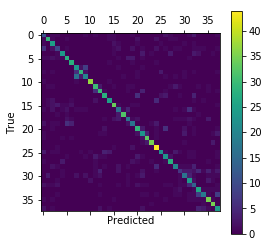

In [50]:
print_test_accuracy( show_confusion_matrix=True )

In [51]:
def plot_conv_weights(weights, input_channel=0):

    
    
    w = session.run(weights)

    w_min = np.min(w)
    w_max = np.max(w)

    num_filters = w.shape[3]

    num_grids = math.ceil(math.sqrt(num_filters))
    
    
    fig, axes = plt.subplots(num_grids, num_grids)

    for i, ax in enumerate(axes.flat):
       
        if i<num_filters:
    
            img = w[:, :, input_channel, i]

            
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    
    
    plt.show()

In [52]:
def plot_conv_layer(layer, image):
  

    feed_dict = {X: [image]}

    values = session.run(layer, feed_dict=feed_dict)

    num_filters = values.shape[3]

    num_grids = math.ceil(math.sqrt(num_filters))
    
    fig, axes = plt.subplots(num_grids, num_grids)

    for i, ax in enumerate(axes.flat):
        if i<num_filters:
            img = values[0, :, :, i]

            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

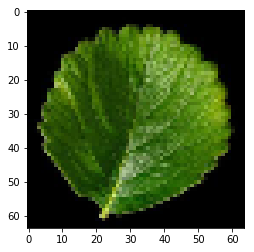

In [53]:
img1 = cv2.imread('test.jpg')
img1 = cv2.resize(img1, (img_size, img_size), cv2.INTER_LINEAR)
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(img1)

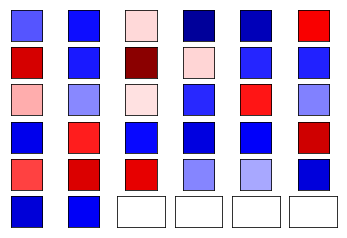

In [54]:
plot_conv_weights(weights=weights_conv_1)

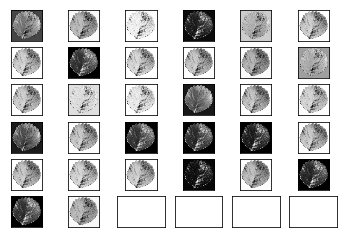

In [55]:
plot_conv_layer(layer=layer_conv_1, image=img1)

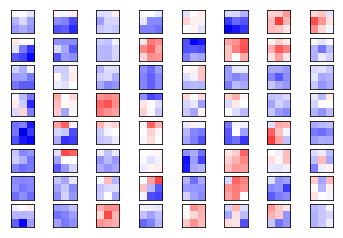

In [56]:
plot_conv_weights(weights=weights_conv_2)

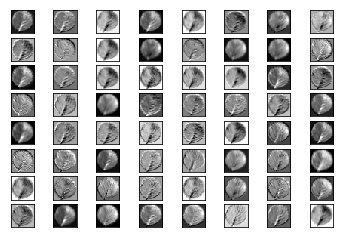

In [57]:
plot_conv_layer(layer=layer_conv_2, image=img1)

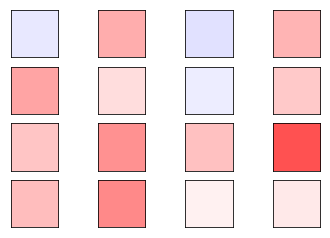

In [58]:
plot_conv_weights(weights=weights_conv_11)

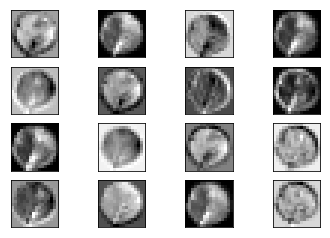

In [59]:
plot_conv_layer(layer=layer_conv_11, image=img1)

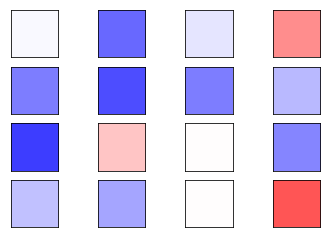

In [60]:
plot_conv_weights(weights=weights_conv_12a)

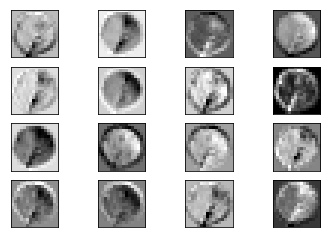

In [61]:
plot_conv_layer(layer=layer_conv_12a, image=img1)

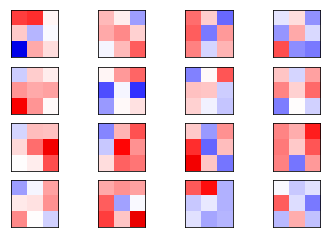

In [62]:
plot_conv_weights(weights=weights_conv_12b)

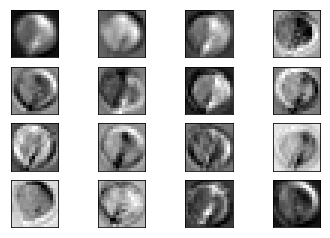

In [63]:
plot_conv_layer(layer=layer_conv_12b, image=img1)

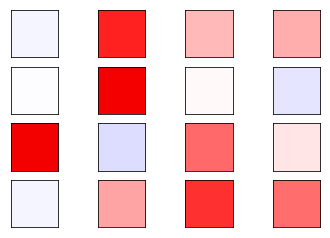

In [64]:
plot_conv_weights(weights=weights_conv_13a)

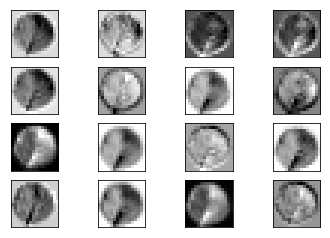

In [65]:
plot_conv_layer(layer=layer_conv_13a, image=img1)

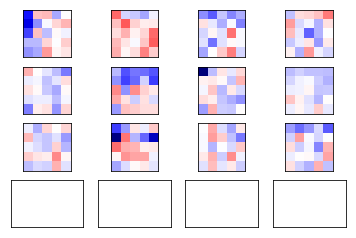

In [66]:
plot_conv_weights(weights=weights_conv_13b)

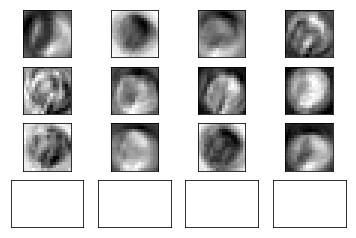

In [67]:
plot_conv_layer(layer=layer_conv_13b, image=img1)

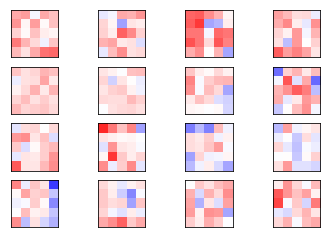

In [68]:
plot_conv_weights(weights=weights_conv_14b)

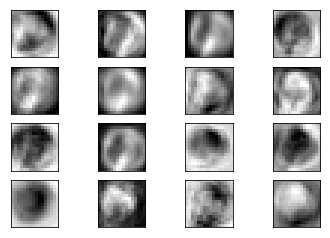

In [69]:
plot_conv_layer(layer=layer_conv_14b, image=img1)

In [70]:
if not os.path.exists('out'):
        os.mkdir('out')

input_node_name = "x"
MODEL_NAME = "incep"
output_node_name = "output"

In [71]:
saver.save(session, 'out/' + MODEL_NAME + '.chkp')

'out/incep.chkp'

In [72]:
tf.train.write_graph(session.graph_def, 'out',MODEL_NAME + '.pbtxt', True)

'out\\incep.pbtxt'

In [73]:
freeze_graph.freeze_graph('out/' + MODEL_NAME + '.pbtxt', None, False,
        'out/' + MODEL_NAME + '.chkp', output_node_name, "save/restore_all",
        "save/Const:0", 'out/frozen_' + MODEL_NAME + '.pb', True, "")

INFO:tensorflow:Restoring parameters from out/incep.chkp
INFO:tensorflow:Froze 20 variables.
INFO:tensorflow:Converted 20 variables to const ops.


In [74]:
input_graph_def = tf.GraphDef()
with tf.gfile.Open('out/frozen_'+MODEL_NAME+'.pb', "rb") as f:
    input_graph_def.ParseFromString(f.read())

In [75]:
output_graph_def = optimize_for_inference_lib.optimize_for_inference(
            input_graph_def, input_node_name, [output_node_name],
            tf.float32.as_datatype_enum)

In [76]:
with tf.gfile.FastGFile('out/opt_' + MODEL_NAME + '.pb', "wb") as f:
        f.write(output_graph_def.SerializeToString())
print("graph saved!")

graph saved!
